In [55]:
import urllib
import bz2
import os

BASE_URL = "http://grail.cs.washington.edu/projects/bal/data/ladybug/"
FILE_NAME = "problem-49-7776-pre.txt.bz2"
URL = BASE_URL + FILE_NAME

if not os.path.isfile(FILE_NAME):
    urllib.request.urlretrieve(URL, FILE_NAME)

In [56]:
def read_bal_data1(file_name):
    with bz2.open(file_name, "rt") as file:
        n_cameras, n_points, n_observations = map(int, file.readline().split())
        print('(カメラ台数, 視点, 観測数)',(n_cameras, n_points, n_observations))

        camera_indices = np.empty(n_observations, dtype=int)
        point_indices = np.empty(n_observations, dtype=int)
        points_2d = np.empty((n_observations, 2))

        for i in range(n_observations):
            camera_index, point_index, x, y = file.readline().split()
            camera_indices[i] = int(camera_index)
            point_indices[i] = int(point_index)
            points_2d[i] = [float(x), float(y)]
        
        camera_params = np.empty(n_cameras * 9)
        for i in range(n_cameras * 9):
            camera_params[i] = float(file.readline())
        camera_params = camera_params.reshape((n_cameras, -1))

        points_3d = np.empty(n_points * 3)
        for i in range(n_points * 3):
            points_3d[i] = float(file.readline())
        points_3d = points_3d.reshape((n_points, -1))

    return camera_params, points_3d, camera_indices, point_indices, points_2d

In [57]:
image_dir = "img"
camera_matrix, distortion_coefficients, rotation_vectors, translation_vectors, points_3d, points_2d  = read_bal_data(image_dir, result_dir='data/calib_result')

Processing: 32
Calibrated 33 images
[[7.55498243e+03 0.00000000e+00 2.72800922e+03]
 [0.00000000e+00 7.59054058e+03 1.37345329e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
[[-2.97993632e-01  9.48250600e+00  2.44860300e-03  1.22051142e-02
  -8.58010674e+01]]
(array([[ 0.17028104],
       [ 0.85538223],
       [-0.23892005]]), array([[ 1.33991632e-01],
       [ 3.45243318e-01],
       [-1.33216549e-04]]), array([[-0.05482518],
       [ 0.36080267],
       [ 0.01251713]]), array([[0.29090469],
       [0.88327347],
       [0.27787866]]), array([[-0.03220187],
       [-0.22532696],
       [ 0.00748541]]), array([[0.15448095],
       [0.69908288],
       [0.12946117]]), array([[ 0.05348354],
       [-0.43825001],
       [-0.00639349]]), array([[-0.03637075],
       [-0.72041198],
       [ 0.07438036]]), array([[ 0.03935318],
       [-0.36022608],
       [-0.02790141]]), array([[-0.24036575],
       [-0.32976374],
       [ 0.02472168]]), array([[ 0.34060054],
       [-0.76101092],
  

In [58]:
camera_params, points_3d, camera_indices, point_indices, points_2d = read_bal_data1(FILE_NAME)

(カメラ台数, 視点, 観測数) (49, 7776, 31843)


In [59]:
print(f"Camera parameters: {camera_params.shape}")
print(f"3D points: {points_3d.shape}")
print(f"Camera indices: {camera_indices.shape}")
print(f"Point indices: {point_indices.shape}")
print(f"2D points: {points_2d.shape}")

Camera parameters: (49, 9)
3D points: (7776, 3)
Camera indices: (31843,)
Point indices: (31843,)
2D points: (31843, 2)


In [60]:
n_cameras = camera_params.shape[0]
n_points = points_3d.shape[0]

n = 9 * n_cameras + 3 * n_points
m = 2 * points_2d.shape[0]

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))
print("Total number of parameters: {}".format(n))
print("Total number of residuals: {}".format(m))

n_cameras: 49
n_points: 7776
Total number of parameters: 23769
Total number of residuals: 63686


In [61]:
def rotate(points, rot_vecs):
    """Rotate points by given rotation vectors.
    
    Rodrigues' rotation formula is used.
    """
    theta = np.linalg.norm(rot_vecs, axis=1)[:, np.newaxis]
    with np.errstate(invalid='ignore'):
        v = rot_vecs / theta
        v = np.nan_to_num(v)
    dot = np.sum(points * v, axis=1)[:, np.newaxis]
    cos_theta = np.cos(theta)
    sin_theta = np.sin(theta)

    return cos_theta * points + sin_theta * np.cross(v, points) + dot * (1 - cos_theta) * v

In [62]:
def project(points, camera_params):
    """Convert 3-D points to 2-D by projecting onto images."""

    points_proj = rotate(points, camera_params[:, :3])
    points_proj += camera_params[:, 3:6]
    points_proj = -points_proj[:, :2] / points_proj[:, 2, np.newaxis]
    f = camera_params[:, 6]
    k1 = camera_params[:, 7]
    k2 = camera_params[:, 8]
    n = np.sum(points_proj**2, axis=1)
    r = 1 + k1 * n + k2 * n**2
    points_proj *= (r * f)[:, np.newaxis]
    return points_proj

In [89]:
def fun(params, n_cameras, n_points, camera_indices, point_indices, points_2d):
    """Compute residuals.
    
    `params` contains camera parameters and 3-D coordinates.
    """

    camera_params = params[:n_cameras * 9].reshape((n_cameras, 9))    
    points_3d = params[n_cameras * 9:].reshape((n_points, 3))
    print(camera_params)
    # インデックスと配列サイズの検証
    print("最小カメラインデックス:", np.min(camera_indices), "カメラパラメータ配列サイズ:", camera_params.shape[0])
    print("最小ポイントインデックス:", np.min(point_indices), "ポイント3D配列サイズ:", points_3d.shape[0])
    print("最大カメラインデックス:", np.max(camera_indices), "カメラパラメータ配列サイズ:", camera_params.shape[0])
    print("最大ポイントインデックス:", np.max(point_indices), "ポイント3D配列サイズ:", points_3d.shape[0])
    points_proj = project(points_3d[point_indices], camera_params[camera_indices])
    return (points_proj - points_2d).ravel()

In [90]:
from scipy.sparse import lil_matrix

def bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices):
    m = camera_indices.size * 2
    n = n_cameras * 9 + n_points * 3
    A = lil_matrix((m, n), dtype=int)

    i = np.arange(camera_indices.size)
    for s in range(9):
        A[2 * i, camera_indices * 9 + s] = 1
        A[2 * i + 1, camera_indices * 9 + s] = 1

    for s in range(3):
        A[2 * i, n_cameras * 9 + point_indices * 3 + s] = 1
        A[2 * i + 1, n_cameras * 9 + point_indices * 3 + s] = 1

    return A

In [91]:
print('n_cameras:', n_cameras)
print('n_points:', n_points)
print('camera_indices:', camera_indices.shape)
print('point_indices:', point_indices.shape)
print('points_2d:', points_2d.shape)
print('camera_params:', camera_params.shape)

n_cameras: 49
n_points: 7776
camera_indices: (31843,)
point_indices: (31843,)
points_2d: (31843, 2)
camera_params: (49, 9)


In [92]:
print('camera_params:', camera_params)
print('points_3d:', points_3d)
print('camera_indices:', camera_indices)
print('point_indices:', point_indices)
print('points_2d:', points_2d)

camera_params: [[ 1.57415159e-02 -1.27909362e-02 -4.40084981e-03 -3.40938396e-02
  -1.07513871e-01  1.12022403e+00  3.99751526e+02 -3.17706439e-07
   5.88204905e-13]
 [ 1.59773241e-02 -2.52244646e-02 -9.40014165e-03 -8.56676614e-03
  -1.21880491e-01  7.19013308e-01  4.02017534e+02 -3.78047656e-07
   9.30743117e-13]
 [ 1.43350562e-02 -2.81315414e-03 -6.40993429e-03 -3.65177353e-02
  -9.83218886e-02  1.31421764e+00  3.99452028e+02 -3.17117899e-07
   5.49809133e-13]
 [ 1.48462512e-02 -2.10628994e-02 -1.16694801e-03 -2.49509707e-02
  -1.13984705e-01  9.21660207e-01  4.00401754e+02 -3.29526462e-07
   6.73288507e-13]
 [ 1.43827673e-02  1.44371556e-03 -6.33309273e-03 -4.67982130e-02
  -9.05954259e-02  1.50186145e+00  3.99337018e+02 -3.20588687e-07
   5.37737811e-13]
 [ 1.25469353e-02 -2.08981319e-02 -6.37574998e-03  1.16857754e-02
  -1.26836217e-01  5.14163665e-01  4.02534992e+02 -3.85810948e-07
   1.04985043e-12]
 [ 1.35959608e-02  4.56857665e-03 -6.13679972e-03 -5.66482238e-02
  -8.31446963

(23769,)
[[ 1.57415159e-02 -1.27909362e-02 -4.40084981e-03 -3.40938396e-02
  -1.07513871e-01  1.12022403e+00  3.99751526e+02 -3.17706439e-07
   5.88204905e-13]
 [ 1.59773241e-02 -2.52244646e-02 -9.40014165e-03 -8.56676614e-03
  -1.21880491e-01  7.19013308e-01  4.02017534e+02 -3.78047656e-07
   9.30743117e-13]
 [ 1.43350562e-02 -2.81315414e-03 -6.40993429e-03 -3.65177353e-02
  -9.83218886e-02  1.31421764e+00  3.99452028e+02 -3.17117899e-07
   5.49809133e-13]
 [ 1.48462512e-02 -2.10628994e-02 -1.16694801e-03 -2.49509707e-02
  -1.13984705e-01  9.21660207e-01  4.00401754e+02 -3.29526462e-07
   6.73288507e-13]
 [ 1.43827673e-02  1.44371556e-03 -6.33309273e-03 -4.67982130e-02
  -9.05954259e-02  1.50186145e+00  3.99337018e+02 -3.20588687e-07
   5.37737811e-13]
 [ 1.25469353e-02 -2.08981319e-02 -6.37574998e-03  1.16857754e-02
  -1.26836217e-01  5.14163665e-01  4.02534992e+02 -3.85810948e-07
   1.04985043e-12]
 [ 1.35959608e-02  4.56857665e-03 -6.13679972e-03 -5.66482238e-02
  -8.31446963e-02  

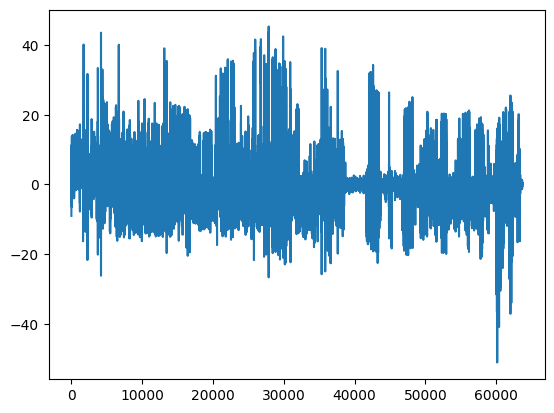

In [93]:
%matplotlib inline
import matplotlib.pyplot as plt
x0 = np.hstack((camera_params.ravel(), points_3d.ravel()))
print(x0.shape)
f0 = fun(x0, n_cameras, n_points, camera_indices, point_indices, points_2d)
plt.plot(f0)

In [67]:
cam = x0[:n_cameras * 9].reshape((n_cameras, 9))
cam

array([[ 1.57415159e-02, -1.27909362e-02, -4.40084981e-03,
        -3.40938396e-02, -1.07513871e-01,  1.12022403e+00,
         3.99751526e+02, -3.17706439e-07,  5.88204905e-13],
       [ 1.59773241e-02, -2.52244646e-02, -9.40014165e-03,
        -8.56676614e-03, -1.21880491e-01,  7.19013308e-01,
         4.02017534e+02, -3.78047656e-07,  9.30743117e-13],
       [ 1.43350562e-02, -2.81315414e-03, -6.40993429e-03,
        -3.65177353e-02, -9.83218886e-02,  1.31421764e+00,
         3.99452028e+02, -3.17117899e-07,  5.49809133e-13],
       [ 1.48462512e-02, -2.10628994e-02, -1.16694801e-03,
        -2.49509707e-02, -1.13984705e-01,  9.21660207e-01,
         4.00401754e+02, -3.29526462e-07,  6.73288507e-13],
       [ 1.43827673e-02,  1.44371556e-03, -6.33309273e-03,
        -4.67982130e-02, -9.05954259e-02,  1.50186145e+00,
         3.99337018e+02, -3.20588687e-07,  5.37737811e-13],
       [ 1.25469353e-02, -2.08981319e-02, -6.37574998e-03,
         1.16857754e-02, -1.26836217e-01,  5.141636

In [68]:
cam.shape

(49, 9)

In [69]:
A = bundle_adjustment_sparsity(n_cameras, n_points, camera_indices, point_indices)

In [70]:
import time
from scipy.optimize import least_squares

t0 = time.time()
res = least_squares(fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(n_cameras, n_points, camera_indices, point_indices, points_2d))
t1 = time.time()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.5091e+05                                    8.57e+06    
       1              3         5.0985e+04      8.00e+05       1.46e+02       1.15e+06    
       2              4         1.6077e+04      3.49e+04       2.59e+01       2.43e+05    
       3              5         1.4163e+04      1.91e+03       2.86e+02       1.21e+05    
       4              7         1.3695e+04      4.67e+02       1.32e+02       2.51e+04    
       5              8         1.3481e+04      2.14e+02       2.24e+02       1.54e+04    
       6              9         1.3436e+04      4.56e+01       3.17e+02       2.72e+04    
       7             10         1.3422e+04      1.35e+01       6.83e+01       2.18e+03    
       8             11         1.3418e+04      3.66e+00       1.24e+02       7.76e+03    
       9             12         1.3414e+04      4.07e+00       2.62e+01       6.27e+02    

In [71]:
print("Optimization took {0:.0f} seconds".format(t1 - t0))

Optimization took 12 seconds


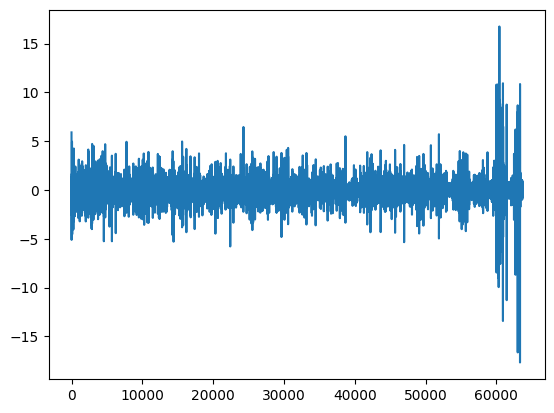

In [72]:
plt.plot(res.fun)